
# HalfCheetah: Learn a Dynamics Model from Random Rollouts (Then Validate It)

**Goal:** In this notebook you'll (1) collect random experience tuples \((s_t, a_t, r_t, s_{t+1})\) from `HalfCheetah-v4`, (2) train a neural network to predict **state deltas** \(\Delta s = s_{t+1}-s_t\), and (3) **validate** the model with one-step and multi-step (open-loop) rollouts.

This mirrors the first phase of model-based control (e.g., MPPI): learn a model offline, then use it for planning.



## 0. Requirements

- Python 3.9+
- PyTorch `>= 1.10`
- Gymnasium `>= 0.29`
- MuJoCo with `HalfCheetah-v4` (install `mujoco` and `gymnasium[mujoco]`)

```bash
pip install "gymnasium[mujoco]" mujoco torch matplotlib
```

**Try and understand what RunningNormalizer does.**


In [3]:
!pip install "gymnasium[mujoco]" mujoco torch matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 138.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 24.9 MB/s eta 0:00:00


In [4]:

import os, math, random, time
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

def to_t(x):
    return th.as_tensor(x, dtype=th.float32)

def fanin_init(m):
    if isinstance(m, nn.Linear):
        bound = 1.0 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, +bound)
        nn.init.zeros_(m.bias)

class RunningNormalizer:
    """Feature-wise running mean/std (Welford)."""
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        self.count = 0
        self.mean = np.zeros(dim, dtype=np.float64)
        self.M2   = np.zeros(dim, dtype=np.float64)
        self.eps  = eps

    def update(self, x: np.ndarray):
        x = np.asarray(x)
        if x.ndim == 1: x = x[None, :]
        for v in x:
            self.count += 1
            d = v - self.mean
            self.mean += d / self.count
            d2 = v - self.mean
            self.M2 += d * d2

    @property
    def var(self):
        if self.count < 2: return np.ones(self.dim, dtype=np.float64)
        return self.M2 / (self.count - 1 + 1e-12)

    @property
    def std(self):
        return np.sqrt(self.var + self.eps)

    def normalize(self, x): return (x - self.mean) / self.std
    def denormalize(self, x): return x * self.std + self.mean

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); th.manual_seed(seed)



## Initializing Environment and Figure Out Observation Structure

`HalfCheetah-v4` exposes observations as `[qpos[1:], qvel[:]]`. The forward velocity is `qvel[0]`, which sits at index `len(qpos[1:])` inside the observation vector. We'll extract that index for later validation/plots. :::: This is important for planning, if we want to know what each state represents


In [5]:

set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_low = env.action_space.low
act_high = env.action_space.high

# Find start index of qvel inside obs = [qpos[1:], qvel[:]]
nq = env.unwrapped.model.nq
qvel_start = int(nq - 1)
print("obs_dim:", obs_dim, "act_dim:", act_dim, "qvel_start:", qvel_start)


obs_dim: 17 act_dim: 6 qvel_start: 8


## 🧩 Task 1: Prepare the Replay Buffer
**Goal:** Store transitions \((s_t, a_t, s_{t+1})\) and return training pairs \((x, y) = (s_t, a_t, s_{t+1} - s_t)\).

**Instructions:**
- Implement `add()` to record transitions.
- Add a `sample()` method to randomly sample batch of certain size.



In [6]:

class Replay:
    def __init__(self, obs_dim, act_dim, capacity=300_000):
        self.obs = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.act = np.zeros((capacity, act_dim), dtype=np.float32)
        self.nxt = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.rew = np.zeros((capacity, 1), dtype=np.float32)
        self.term = np.zeros((capacity, 1), dtype=np.float32)
        self.ptr = 0; self.size = 0; self.cap = capacity

    def add(self, s, a, r, sp, term):
        i = self.ptr
        self.obs[i] = s; self.act[i] = a; self.rew[i] = r
        self.nxt[i] = sp; self.term[i] = term
        self.ptr = (i + 1) % self.cap
        self.size = min(self.size + 1, self.cap)

    def sample(self, batch):
        idx = np.random.randint(0, self.size, size=batch)
        return self.obs[idx], self.act[idx], self.rew[idx], self.nxt[idx], self.term[idx]

replay = Replay(obs_dim, act_dim)



## Task 2. Collect Random Rollouts

- Gather random actions for a number of steps to create our training dataset. Collect data for 100000 steps.
- Call the function and fill the replay buffer


In [7]:

def collect_random(env, replay, steps=10000, seed=42):
    s, _ = env.reset(seed=seed)
    ret = 0.0
    for _ in range(steps):
        a = env.action_space.sample()
        sp, r, term, trunc, _ = env.step(a)
        replay.add(s, a, r, sp, float(term or trunc))
        ret += r
        s = sp
        if term or trunc:
            s, _ = env.reset()
    return ret

total_return = collect_random(env, replay, steps=200000, seed=42)
print("Collected transitions:", replay.size, "example return:", total_return)


Collected transitions: 200000 example return: -57566.90989478855



## Task 3. Update normalizers from the collected random data in the replay buffer

We normalize inputs (`[s,a]`) and targets (`Δs = s' - s`) for stable training.


In [8]:

obs_norm = RunningNormalizer(obs_dim)
inp_norm = RunningNormalizer(obs_dim + act_dim)
targ_norm = RunningNormalizer(obs_dim)

def update_normalizers_from_buffer(replay, maxN=50000):
    n = min(replay.size, maxN)
    idx = np.random.choice(replay.size, size=n, replace=False)
    obs = replay.obs[idx]; act = replay.act[idx]; nxt = replay.nxt[idx]
    delta = nxt - obs
    xin = np.concatenate([obs, act], axis=1)
    obs_norm.update(obs)
    inp_norm.update(xin)
    targ_norm.update(delta)

update_normalizers_from_buffer(replay)
print("Normalizers ready.")


Normalizers ready.



## Defining the Neural Dynamics Model

We predict **normalized** `Δs` from **normalized** `[s, a]`.
NN parameters:

- initialize a deterministic NN with a ExponentialLR sceduler( that decays the learning rate with epoch)
- width = 200, depth = 3, lr = 1e-3, weight_decay - 1e-5, gamma for scheduler = 0.8
- These are a starting point but not the best parameters.


In [9]:

class DetMLP(nn.Module):
    """Predicts Δstate deterministically."""
    def __init__(self, in_dim, out_dim, width=200, depth=3):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU()]
            last = width
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
        self.apply(fanin_init)

    def forward(self, x):
        return self.net(x)

in_dim = obs_dim + act_dim
out_dim = obs_dim
model = DetMLP(in_dim, out_dim, width=200, depth=3)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)



## Task 4. Train the Model

We minimize MSE between predicted normalized `Δs` and target normalized `Δs`.

- Train in batches, keep the batch size 256
- Use a learning rate scheduler that decays the learning rate as training progresses. You may use the pytorch utility. See how the learning rate decays with each epoch.
- Train for 30 epochs and plot the training curve. Loss vs epoch.
- Find the best parameters(defined in the previous block)



Epoch 001 | loss=0.075070 | lr=0.000800
Epoch 002 | loss=0.036140 | lr=0.000640
Epoch 003 | loss=0.027059 | lr=0.000512
Epoch 004 | loss=0.022511 | lr=0.000410
Epoch 005 | loss=0.019600 | lr=0.000328
Epoch 006 | loss=0.017841 | lr=0.000262
Epoch 007 | loss=0.016527 | lr=0.000210
Epoch 008 | loss=0.015293 | lr=0.000168
Epoch 009 | loss=0.014508 | lr=0.000134
Epoch 010 | loss=0.013995 | lr=0.000107


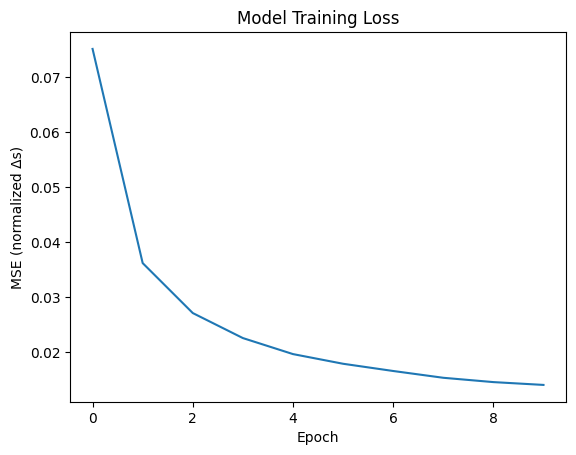

In [10]:

def sample_batch(replay, batch):
    s, a, _, sp, _ = replay.sample(batch)
    delta = sp - s
    xin = np.concatenate([s, a], axis=1)
    xin_n = to_t(inp_norm.normalize(xin))
    delta_n = to_t(targ_norm.normalize(delta))
    return xin_n, delta_n

def train_model(model, replay, epochs=30, batch_size=256):
    losses = []
    model.train()
    for ep in range(epochs):
        s = 0.0
        iters = max(1, replay.size // batch_size)
        for _ in range(iters):
            xin_n, delta_n = sample_batch(replay, batch_size)
            opt.zero_grad()
            pred = model(xin_n)
            loss = nn.functional.mse_loss(pred, delta_n)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
            s += float(loss.item())
        s /= iters
        losses.append(s)
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {ep+1:03d} | loss={s:.6f} | lr={current_lr:.6f}")
    return losses

losses = train_model(model, replay, epochs=10, batch_size=64)
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized Δs)")
plt.title("Model Training Loss")
plt.show()


## Task 5. Validate your model: One-Step and Multi-Step Prediction Error

- Evaluate your trained model on a held-out set of random transitions.
Generate a batch of unseen samples, predict the next-state delta, and compute the one-step MSE.

- Repeat with open-loop rollouts of length k.
Drive both the real environment and the model with the same action sequence, then report how prediction error grows across steps.

In [11]:

# your code here

def one_step_mse(model, replay, holdout=5000):
    model.eval()
    n = min(holdout, replay.size)
    idx = np.random.choice(replay.size, size=n, replace=False)
    s = replay.obs[idx]; a = replay.act[idx]; sp = replay.nxt[idx]
    delta = sp - s
    xin = np.concatenate([s, a], axis=1)

    xin_n = to_t(inp_norm.normalize(xin))
    pred_n = model(xin_n).detach().numpy()
    pred = targ_norm.denormalize(pred_n)

    mse = np.mean((pred - delta)**2)
    return float(mse)

mse_1 = one_step_mse(model, replay, holdout=5000)
print("One-step MSE (Δs):", mse_1)

One-step MSE (Δs): 0.2934293578271173


In [12]:

def k_step_open_loop_error(env, model, k=20, trials=10, seed=123):
    model.eval()
    rng = np.random.default_rng(seed)
    errors = []

    for _ in range(trials):
        s, _ = env.reset(seed=int(rng.integers(0, 10_000)))
        s_real = s.copy()
        s_model = s.copy()

        # fixed random actions to drive both systems identically
        acts = [env.action_space.sample() for __ in range(k)]

        err_sum = 0.0
        for t in range(k):
            a = acts[t]

            # real env
            sp_real, _, term, trunc, _ = env.step(a)
            # model step
            xin = np.concatenate([s_model[None, :], a[None, :]], axis=1)
            xin_n = to_t(inp_norm.normalize(xin))
            delta_n = model(xin_n).detach().numpy()
            delta = targ_norm.denormalize(delta_n)[0]
            sp_model = s_model + delta

            err_sum += np.mean((sp_model - sp_real)**2)

            s_real = sp_real
            s_model = sp_model
            if term or trunc:
                break

        errors.append(err_sum / max(1, t+1))

    return float(np.mean(errors))

mse_k = k_step_open_loop_error(env, model, k=20, trials=5)
print("Avg k-step (k=20) open-loop MSE:", mse_k)


Avg k-step (k=20) open-loop MSE: 0.9489752809299071



## Task 6. Visualize Rollout Trajectories

**Setup**
Call model.eval() so gradients stay off.
Reset the env with the provided seed; keep a copy of the initial observation.


**Choose actions**
Pre-sample k actions from env.action_space.sample() so the real system and the model rollout see the same sequence.

**Roll forward**
For each action:
Step the real env (env.step(a)), append the new observation.
For the model path:
Build [s_model, a], normalize via inp_norm.normalize, turn into a tensor with to_t.
Run the network, de-normalize with targ_norm.denormalize, add to the last model state, append.
Stop early if the env terminates or truncates.

**Plot**
Plot the real trajectory as one line, model trajectory as another.



[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


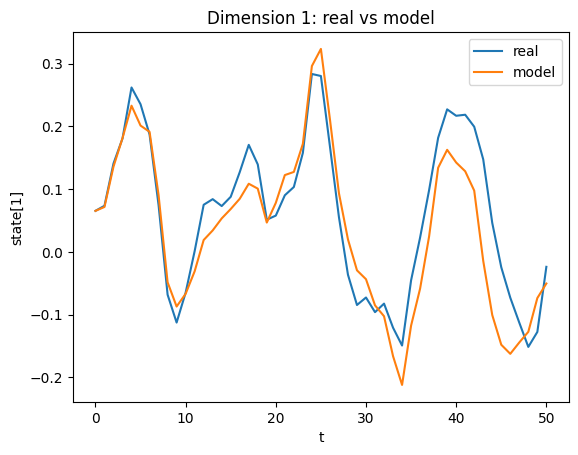

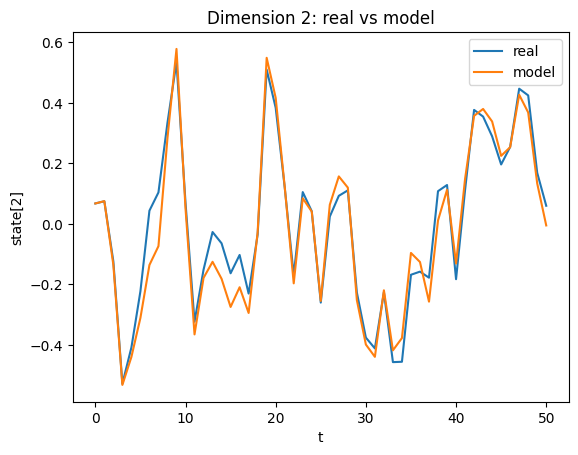

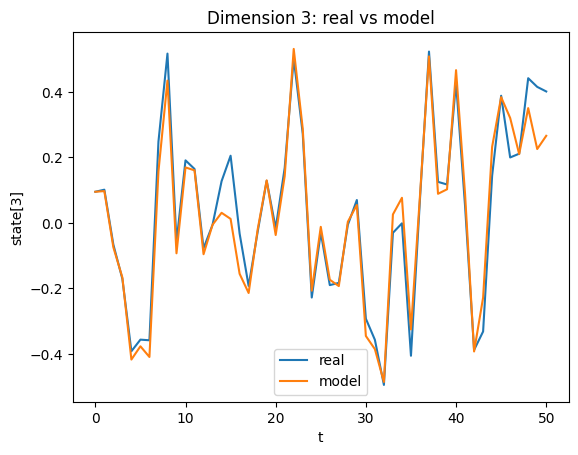

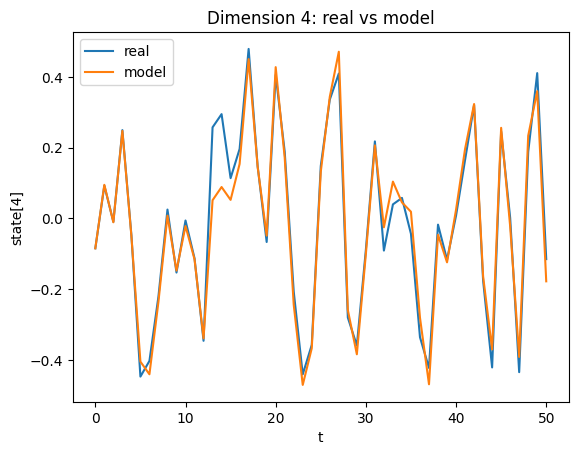

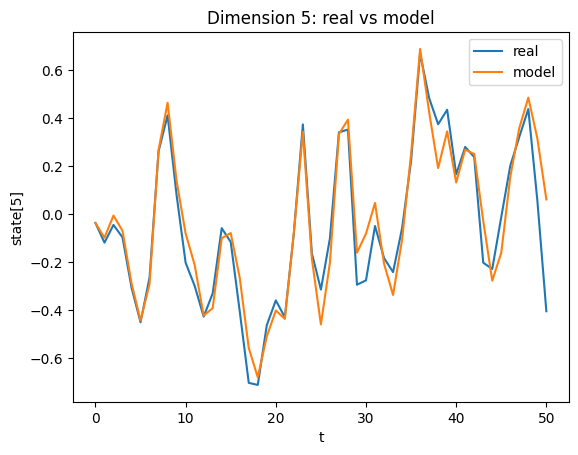

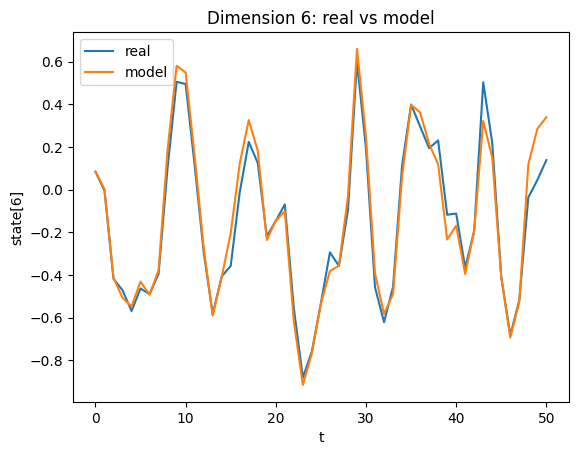

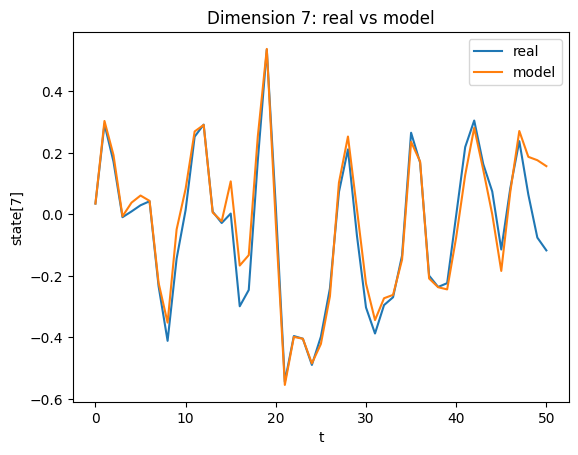

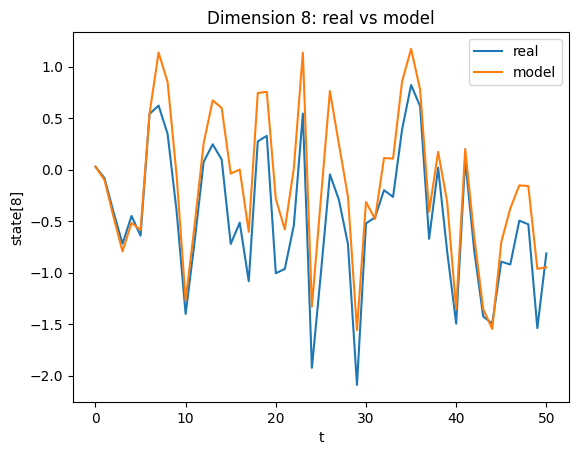

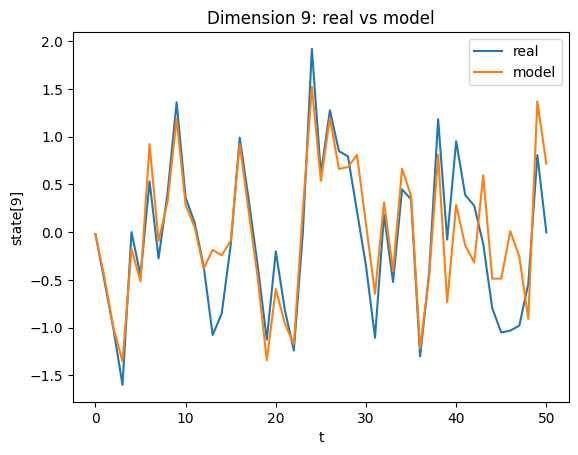

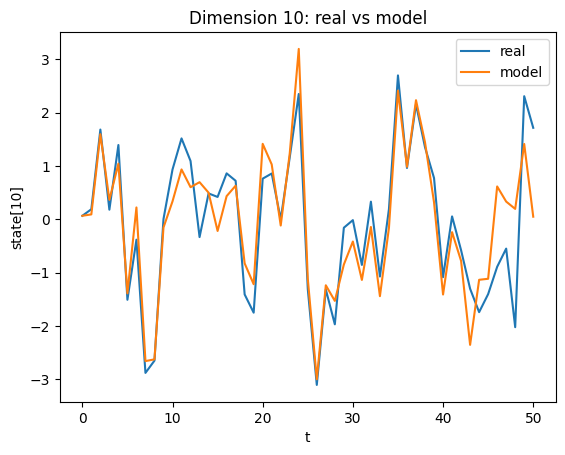

In [13]:

def visualize_rollout(env, model, k=50, dims=(0, 5, 10), seed=2025):
    model.eval()
    s, _ = env.reset(seed=seed)
    s_real = s.copy()
    s_model = s.copy()
    acts = [env.action_space.sample() for _ in range(k)]

    traj_real = [s_real.copy()]
    traj_model = [s_model.copy()]
    for t in range(k):
        a = acts[t]
        sp_real, _, term, trunc, _ = env.step(a)

        xin = np.concatenate([s_model[None, :], a[None, :]], axis=1)
        xin_n = to_t(inp_norm.normalize(xin))
        delta_n = model(xin_n).detach().numpy()
        delta = targ_norm.denormalize(delta_n)[0]
        sp_model = s_model + delta

        traj_real.append(sp_real.copy())
        traj_model.append(sp_model.copy())

        s_real = sp_real
        s_model = sp_model
        if term or trunc:
            break

    traj_real = np.array(traj_real)
    traj_model = np.array(traj_model)

    print(dims)
    for d in dims:
        plt.figure()
        plt.plot(traj_real[:, d], label="real")
        plt.plot(traj_model[:, d], label="model")
        plt.xlabel("t")
        plt.ylabel(f"state[{d}]")
        plt.title(f"Dimension {d}: real vs model")
        plt.legend()
        plt.show()

# Uncomment to visualize
dims = list(range(1, 11))
visualize_rollout(env, model, k=50, dims=dims)#(qvel_start, qvel_start+1, qvel_start+2))



## 9. Answer the questions :

1. How good is your model?
2. Is this training enough for planning, or do we need continual training?
3. How is this system different from the mountain car problem? Why can't we learn this in one episode?
4. Why do we use a runningnormalizer instead of a static normalizer? Think about the nature of the algorithm taught in class.

